# Cloning the Repository (pc-gym)

In [1]:
!dir pc-gym

 Volume in drive C is Windows 
 Volume Serial Number is F0B8-32A3

 Directory of c:\Users\Usuario\Desktop\imperial_projects\VSCode\pcgym\venv\pc-gym

18/04/2024  15:03    <DIR>          .
27/06/2024  15:50    <DIR>          ..
18/04/2024  14:56    <DIR>          .github
18/04/2024  14:56             2,940 .gitignore
18/04/2024  14:56    <DIR>          Control-Club-Challenge
18/04/2024  14:56    <DIR>          docs
18/04/2024  14:56               179 environment.yml
18/04/2024  14:56    <DIR>          example_notebooks
18/04/2024  14:56             1,094 LICENSE
18/04/2024  14:56             3,599 mkdocs.yml
18/04/2024  15:03    <DIR>          pc-gym
18/04/2024  14:56             1,309 pyproject.toml
18/04/2024  14:56           132,281 Quick_Start.ipynb
18/04/2024  14:56             3,972 README.md
18/04/2024  14:56                95 requirements.txt
18/04/2024  15:28    <DIR>          src
               8 File(s)        145,469 bytes
               8 Dir(s)  264,338,907,136 bytes free


In [2]:
%cd pc-gym

c:\Users\Usuario\Desktop\imperial_projects\VSCode\pcgym\venv\pc-gym


c:\Users\Usuario\Desktop\imperial_projects\VSCode\pcgym\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Importing Libraries

In [3]:
%cd src

c:\Users\Usuario\Desktop\imperial_projects\VSCode\pcgym\venv\pc-gym\src


In [4]:
from dataclasses import dataclass
import numpy as np
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
import torch.nn.functional as F
import copy
from stable_baselines3 import PPO,SAC,DDPG,TD3
import pcgym
from pcgym.pcgym import make_env
import jax.numpy as jnp
#Global params
T = 26
nsteps = 100

# Saving and loading

Saving and loading stable-baselines models is straightforward: you can directly call `.save()` and `.load()` on the models.

In [5]:
import os
# Create save dir
save_dir = "C:/Users/Usuario/Desktop/imperial_projects/VSCode/pcgym/paper_base_opt_train_eval"
os.makedirs(save_dir, exist_ok=True)

# Monitoring experiments with W&B

In [6]:
# !wandb login
# api_key: 84af17cc9914cf1736f3a8e2733a2f361e4750bb

!wandb login 84af17cc9914cf1736f3a8e2733a2f361e4750bb

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Usuario\.netrc


# 1.1 Reactor Case Study

In [7]:
# @title Function to log the performance data
def log_performance(performance, test_label, file_path):
    with open(file_path, "a") as file:
        file.write(f"{test_label}: \n")
        file.write(f"scalarised_performance: {performance}\n\n")

file_path = f"{save_dir}/lcb_metric_safe.txt"

### RL training

In [8]:
import torch as th
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv

##################################################################################
# Environment and RL Definition
##################################################################################

# Global params
T = 26
nsteps = 100

# Global seed for reproducibility
seed = 1990

# Enter required setpoints for each state. Enter None for states without setpoints.
SP = {
    'T': [324.475443431599 for _ in range(5)] + [340.0 for _ in range(nsteps - 5)],
}

# Continuous box action space
action_space = {
    'low': np.array([250]),
    'high': np.array([350])
}

# Continuous box observation space ([CA, T, CA_Setpoint, T_Setpoint])
observation_space = {
    'low': np.array([0.0, 200, 300]),
    'high': np.array([1, 600, 400])
}

r_scale = {
    'T': 1e-6  # Reward scale for each state,
}

# Define disturbance bounds
disturbance_bounds = {
    'low': np.array([350]),
    'high': np.array([450])
}

# Environment parameters
env_params_template = {
    'Nx': 2,
    'N': 100,
    'tsim': 26,
    'Nu': 1,
    'SP': SP,
    'o_space': observation_space,
    'a_space': action_space,
    'x0': np.array([0.87725294608097, 324.475443431599, 324.475443431599]),
    'model': 'cstr_ode',
    'r_scale': r_scale,
    'normalise_a': True,
    'normalise_o': True,
    'noise': True,
    'integration_method': 'casadi',
    'noise_percentage': 0.001,
    'disturbance_bounds': disturbance_bounds
}

# Function to create random disturbances
def create_random_disturbances(seed, nsteps, low=350, high=450):
    np.random.seed(seed)
    values = np.random.uniform(low, high, 3)  # Generate three random disturbance values within the specified range
    times = np.sort(np.random.choice(range(1, nsteps - 1), 2, replace=False))  # Select two unique time steps for disturbances
    times = np.append(times, nsteps)  # Append the total number of steps to get three periods
    times = np.diff([0] + times.tolist())  # Calculate the duration of each disturbance period
    disturbances = {'Ti': np.repeat(values, times)}  # Repeat the disturbance values according to the calculated durations
    return disturbances

# Create multiple environments with different disturbances
def create_parallel_envs(n_envs, seed):
    envs = []
    disturbances_list = []
    for i in range(n_envs):
        env_params = env_params_template.copy()
        disturbances = create_random_disturbances(seed + i, nsteps)
        env_params.update({'disturbances': disturbances})
        disturbances_list.append(disturbances)
        envs.append(lambda: make_env(env_params))
    return SubprocVecEnv(envs), disturbances_list

# Learning rate decay schedule
def cosine_annealing_schedule(progress_remaining: float, num_cycles=1, min_lr=0.005, max_lr=0.01):
    progress = 1.0 - progress_remaining
    lr = min_lr + (max_lr - min_lr) / 2 * (1 + np.cos(np.pi * num_cycles * progress))
    return lr

# Best common parameters found
best_params = {
    'ent_coef': 0.004230354144729496,
    'min_lr': 0.004262568221276856,
    'max_lr': 0.01121513839979795,
    'n_steps': 64,  # 71,
    'pi_units': [8, 16],  # 2 ** 3, 2 ** 4
    'vf_units': [16, 8]  # 2 ** 4, 2 ** 3
}

# Configuration for reinforcement learning model
config = {
    "policy": 'MlpPolicy',  # default: MlpPolicy
    "learning_rate": "cosine",  # default: 0.01
    "gamma": 0.99,  # default: 0.99, the discount factor
    "total_timesteps": 5.0e5,  # base: 1.0e5
    "gae_lambda": 0.99,  # default: 0.95, Factor for trade-off of bias vs variance for Generalized Advantage Estimator
    "ent_coef": best_params['ent_coef'],  # default: 0.0, Entropy coefficient for the loss calculation
    "batch_size": 1280,  # default: 128
    "n_steps": best_params['n_steps'],  # default: 2048 # base: 120
    "n_epochs": 10,  # default: 10, number of times the optimizer will go over the collected batch of experiences to update the model
    # rollout buffer size is (n_steps * n_envs) where n_envs is number of environment copies running in parallel
    "clip_range": 0.2,  # default: 0.2
    "clip_range_vf": None,  # default: None # base: 0.2
    "seed": 1990,
    "check_freq": 100,  # base: 12000 (~100 episodes)
    "n_eval_episodes": 10,  # evaluate the agent over 100 episodes in the evaluation environment
    "n_trials": 500,  # Number of trials for Optuna optimization (base: 100)
    "positive_definiteness_penalty_weight": 0,  # Set to 0
    "derivative_penalty_weight": 0,  # Set to 0
}

# Add noise_percentage from env_params to config
config['noise_percentage'] = env_params_template['noise_percentage']

# Custom NN Architecture
policy_kwargs = dict(
    activation_fn=th.nn.Tanh,
    net_arch=dict(pi=best_params['pi_units'], vf=best_params['vf_units'])
)

# Create parallel environments for evaluation
def create_eval_env(seed):
    env_params = env_params_template.copy()
    disturbances = create_random_disturbances(seed, nsteps)
    env_params.update({'disturbances': disturbances})
    env_params.update({'disturbance_bounds': disturbance_bounds})  # Ensure bounds are included
    return make_env(env_params)

# Instantiate the evaluation environment
eval_env = create_eval_env(seed)  # Evaluation environment


In [9]:
import wandb
# from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3 import PPO
import torch
import numpy as np
import os

# Initialize W&B
wandb.init(
    config=config,
    sync_tensorboard=True,  # Automatically upload SB3's tensorboard metrics
    project="pc-gym-paper",
    name=f"train-RL-mult-disturb-ns_{config['n_steps']}-bs_{config['batch_size']}",
)

# Seed everything for reproducibility
seed = 1990
np.random.seed(seed)
torch.manual_seed(seed)

# Number of parallel environments
n_envs = 10

# Create the parallel environments and get the disturbances
env, disturbances_list = create_parallel_envs(n_envs, seed)

# Print the first and second disturbances
print("First disturbance used in training:", disturbances_list[0])
print("Second disturbance used in training:", disturbances_list[1])

# Training the model
model = PPO(
    config['policy'],  # Use the default policy but customize its components
    env,
    learning_rate=lambda progress_remaining: cosine_annealing_schedule(progress_remaining, min_lr=best_params['min_lr'], max_lr=best_params['max_lr']),
    clip_range=config['clip_range'],
    clip_range_vf=config['clip_range_vf'],
    batch_size=config['batch_size'],
    n_steps=config['n_steps'],
    seed=seed,
    gamma=config['gamma'],
    gae_lambda=config['gae_lambda'],
    ent_coef=config['ent_coef'],
    n_epochs=config['n_epochs'],
    policy_kwargs=policy_kwargs,  # Pass custom architecture and function here
    tensorboard_log=f"runs/ppo",
    positive_definiteness_penalty_weight=config['positive_definiteness_penalty_weight'],
    derivative_penalty_weight=config['derivative_penalty_weight'],
)

# Create the evaluation environment
eval_env = create_eval_env(seed)

# Create evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=save_dir,
    log_path=save_dir,
    eval_freq=config['check_freq'],
    n_eval_episodes=config['n_eval_episodes'],
    deterministic=True,
    render=False
)

# Train the model with the callbacks
model.learn(total_timesteps=config['total_timesteps'], callback=eval_callback)

# Save the model
model.save(save_dir + "/pc_gym_paper_mult_disturb")

# Save the disturbances to a file for future reference
disturbances_file_path = os.path.join(save_dir, "disturbances_used_in_training.txt")
with open(disturbances_file_path, "w") as f:
    for i, disturbance in enumerate(disturbances_list):
        f.write(f"Disturbance {i+1}: {disturbance}\n")

# Finish the W&B run
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: josetorraca (lades). Use `wandb login --relogin` to force relogin


First disturbance used in training: {'Ti': array([422.19772575, 422.19772575, 422.19772575, 422.19772575,
       422.19772575, 422.19772575, 422.19772575, 422.19772575,
       422.19772575, 422.19772575, 422.19772575, 422.19772575,
       422.19772575, 422.19772575, 422.19772575, 422.19772575,
       422.19772575, 357.75500577, 357.75500577, 357.75500577,
       357.75500577, 357.75500577, 357.75500577, 357.75500577,
       357.75500577, 357.75500577, 357.75500577, 357.75500577,
       357.75500577, 357.75500577, 357.75500577, 357.75500577,
       357.75500577, 357.75500577, 357.75500577, 357.75500577,
       357.75500577, 357.75500577, 357.75500577, 357.75500577,
       357.75500577, 357.75500577, 357.75500577, 357.75500577,
       357.75500577, 357.75500577, 357.75500577, 357.75500577,
       357.75500577, 357.75500577, 357.75500577, 357.75500577,
       359.76225234, 359.76225234, 359.76225234, 359.76225234,
       359.76225234, 359.76225234, 359.76225234, 359.76225234,
       359.7

c:\Users\Usuario\Desktop\imperial_projects\VSCode\pcgym\venv\Lib\site-packages\stable_baselines3\ppo\ppo.py:159: UserWarning: You have specified a mini-batch size of 1280, but because the `RolloutBuffer` is of size `n_steps * n_envs = 640`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 640
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=64 and n_envs=10)
  warnings.warn(
c:\Users\Usuario\Desktop\imperial_projects\VSCode\pcgym\venv\Lib\site-packages\stable_baselines3\common\callbacks.py:414: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x000001EDBDCDC6E0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x000001EDE8FDA600>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")
c:\Users\Usuario\Desktop\imperial_projects\VSCode\pcgym\venv\Lib\site-

Eval num_timesteps=1000, episode_reward=-0.20 +/- 0.01
Episode length: 100.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-0.26 +/- 0.00
Episode length: 100.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-0.23 +/- 0.00
Episode length: 100.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-0.14 +/- 0.01
Episode length: 100.00 +/- 0.00
New best mean reward!
Eval num_timesteps=5000, episode_reward=-0.09 +/- 0.01
Episode length: 100.00 +/- 0.00
New best mean reward!
Eval num_timesteps=6000, episode_reward=-0.11 +/- 0.00
Episode length: 100.00 +/- 0.00
Eval num_timesteps=7000, episode_reward=-0.13 +/- 0.01
Episode length: 100.00 +/- 0.00
Eval num_timesteps=8000, episode_reward=-0.09 +/- 0.00
Episode length: 100.00 +/- 0.00
Eval num_timesteps=9000, episode_reward=-0.19 +/- 0.01
Episode length: 100.00 +/- 0.00
Eval num_timesteps=10000, episode_reward=-0.09 +/- 0.00
Episode length: 100.00 +/- 0.00
Eval num_timesteps=11000, episode_reward=-0.06 +/- 0.00
Episode

# 2 Testing

In [2]:
# @title Plot deterministic - best policy - Matplotlib
# import wandb
import os
import sys
from stable_baselines3 import PPO

# Evaluate the agent on the first and second disturbances

# Load the best model
# best_model_path = f"{save_dir}/pc_gym_paper_mult_disturb"
best_model_path = f'..\\data\\new\\best_model'
best_model_dist = PPO.load(best_model_path)

# Function to create an environment
def create_env(env_params):
    env = make_env(env_params)
    return env

# Function to create an environment with specific disturbances
def create_eval_env_with_disturbances(seed, disturbances):
    env_params = env_params_template.copy()
    env_params.update({
        'disturbances': disturbances,
        'disturbance_bounds': disturbance_space,
    })
    return create_env(env_params)

# Disturbance bounds for 'Ti'
disturbance_space = {
    'low': np.array([100]),  # Lower bound for 'Ti'
    'high': np.array([600])  # Upper bound for 'Ti'
}

# Create the first and second disturbances
first_disturbance = create_random_disturbances(seed, nsteps)
second_disturbance = create_random_disturbances(seed + 1, nsteps)

# Print the first and second disturbances for comparison
print("First disturbance used in evaluation:", first_disturbance)
print("Second disturbance used in evaluation:", second_disturbance)

# Create environments with the first and second disturbances
env_first = create_eval_env_with_disturbances(seed, first_disturbance)
env_second = create_eval_env_with_disturbances(seed + 1, second_disturbance)

# Number of rollouts for evaluation
rollout_number = 5

# NMPC Parameters optimized for 1st disturbance
# MPC_params = {'N': 20, 'R': 1.402747354740119e-08}
# MPC_params = {'N': 21, 'R': 7.127145774001836e-09}
MPC_params = {'N': 26, 'R': 8.456833303767221e-09}

# Evaluate the model
def evaluate_model(env, model, rollout_number=rollout_number):
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')
    evaluator, data = env.plot_rollout({'PPO': model}, rollout_number, oracle=True, dist_reward=True, MPC_params=MPC_params)
    sys.stdout = sys.__stdout__
    sys.stderr = sys.__stderr__
    return evaluator, data

# Evaluate on the first disturbance
evaluator_first, data_first = evaluate_model(env_first, best_model_dist)
print("Evaluation on first disturbance completed.")

NameError: name 'save_dir' is not defined

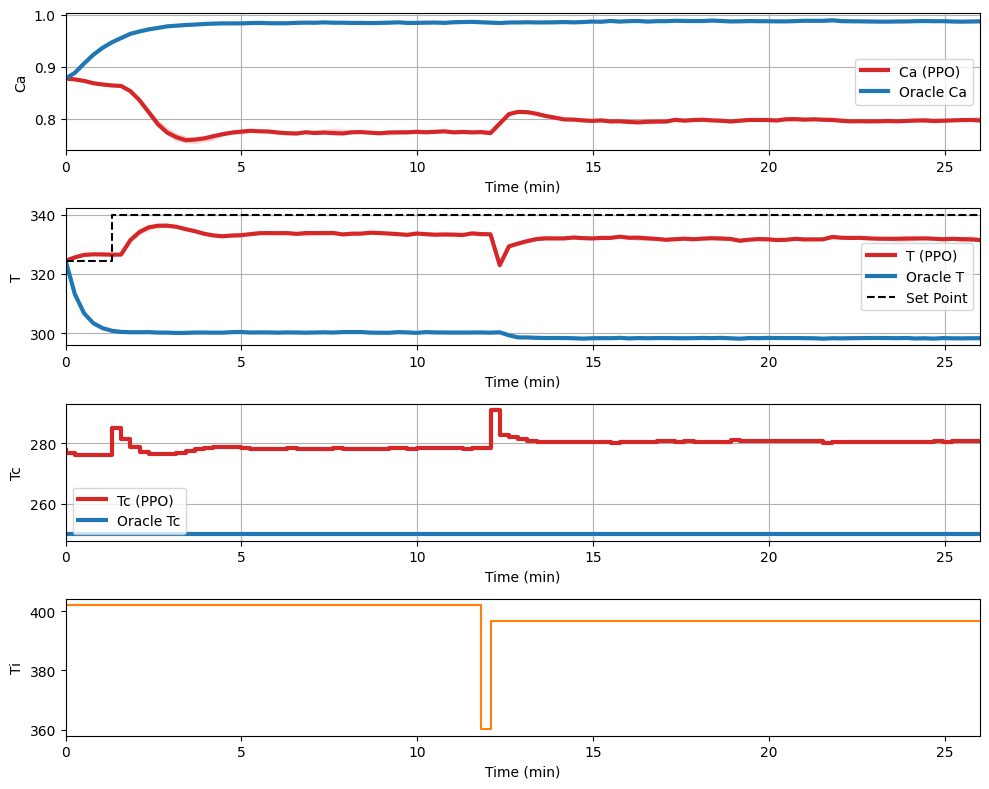

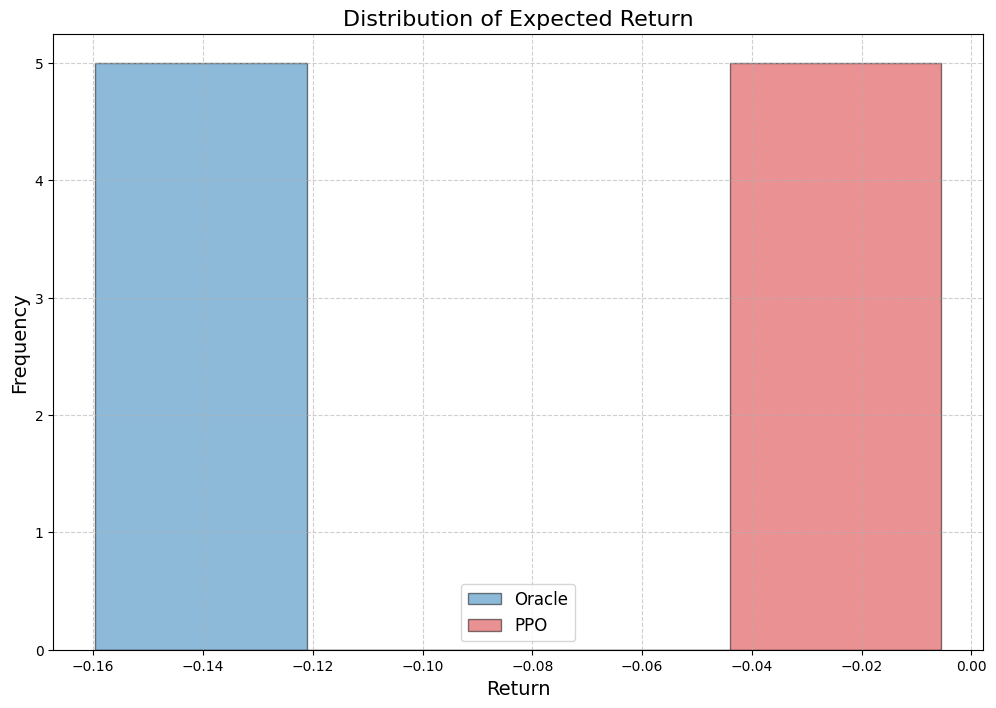

In [ ]:
# Evaluate on the second disturbance

# NMPC Parameters optimized for 2nd disturbance
MPC_params={'N': 8, 'R': 6.11619369085079e-08}

evaluator_second, data_second = evaluate_model(env_second, best_model_dist)
print("Evaluation on second disturbance completed.")

In [ ]:
# @title Log Reproducibility metric
from pcgym.evaluation_metrics import reproducibility_metric

policy_measure = reproducibility_metric(dispersion='mad', performance='mean', scalarised_weight=-1000)
scalarised_performance = policy_measure.evaluate(evaluator_first, component="r",) #component=None)

scalarised_performance

test_label = "1st: Disturbance test"
log_performance(scalarised_performance, test_label, file_path)

In [ ]:
policy_measure = reproducibility_metric(dispersion='mad', performance='mean', scalarised_weight=-1000)
scalarised_performance = policy_measure.evaluate(evaluator_second, component="r",) #component=None)

scalarised_performance

test_label = "2nd: Disturbance test"
log_performance(scalarised_performance, test_label, file_path)

In [ ]:
# @title Plot deterministic - best policy  - W&B
# Evaluate on the first disturbance
wandb.init(
    config=config,
    project="pc-gym-paper",
    name=f"test-RL-base-1st-disturb")

data = data_first

# Assuming the second dimension is the number of steps
num_steps = max(data['oracle']['x'].shape[1], data['PPO']['x'].shape[1])  # Find the max number of steps

# Define the setpoint for temperature logging
SP_log = {
    'T': [324.475443431599 for _ in range(5)] + [340.0 for _ in range(num_steps - 5)],
}

# Loop over steps to log data
for step in range(num_steps):
        # Extracting Oracle data
        Ca_Oracle = data['oracle']['x'][0, step, 0]  # First chemical component
        T_Oracle = data['oracle']['x'][1, step, 0]  # Temperature
        Tc_Oracle = data['oracle']['u'][0, step, 0]  # Control temperature (Tc)
        Reward_Oracle = data['oracle']['r'][0, min(step, data['oracle']['r'].shape[1]-1)]
        # Extracting PPO data
        Ca_PPO = data['PPO']['x'][0, step, 0]  # First chemical component
        T_PPO = data['PPO']['x'][1, step, 0]  # Temperature
        # Set_Point = data['PPO']['x'][2, step, 0]   # Set Point
        Disturbances = data['PPO']['x'][3, step, 0]   # Disturbances
        Tc_PPO = data['PPO']['u'][0, step, 0]  # Control temperature (Tc)
        Reward_PPO = data['PPO']['r'][0, min(step, data['PPO']['r'].shape[1]-1)]

        # Log these values to W&B for Oracle
        wandb.log({
            "step_index": step,
            "Ca_Oracle": Ca_Oracle,
            "T_Oracle": T_Oracle,
            "Tc_Oracle": Tc_Oracle,
            "Reward_Oracle": Reward_Oracle,
            "Ca_PPO": Ca_PPO,
            "T_PPO": T_PPO,
            "Tc_PPO": Tc_PPO,
            "Reward_PPO": Reward_PPO,
            "Set_Point_RL": SP_log['T'][step],
            "Disturbances": Disturbances,
        }, step=step)

# Finish the run
wandb.finish()

Ca_Oracle,███▇▆▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▂▂▃▃▃▃▄▃▃▂▂▃▃▄▄▄▄
Ca_PPO,██▇▇▄▁▄▆▇███████████████████████████████
Disturbances,████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Reward_Oracle,▁█▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
Reward_PPO,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Set_Point_RL,▁▁██████████████████████████████████████
T_Oracle,▁▂▂▃▅▆▇▇██▇▇▇▇▇████▇█▇▇▇▇▆▆▆▆▆▇▇▇▇▆▆▅▅▅▆
T_PPO,▂▃▃▃██▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂
Tc_Oracle,▁▁▁▂▂▁▁▁█▇▇██████████████████████████▇██
Tc_PPO,▅▄▄▄▁▁▅▅████████████████████████████████
step_index,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [ ]:
# Evaluate on the second disturbance
wandb.init(
    config=config,
    project="pc-gym-paper",
    name=f"test-RL-base-2nd-disturb")

data = data_second

# Assuming the second dimension is the number of steps
num_steps = max(data['oracle']['x'].shape[1], data['PPO']['x'].shape[1])  # Find the max number of steps

# Define the setpoint for temperature logging
SP_log = {
    'T': [324.475443431599 for _ in range(5)] + [340.0 for _ in range(num_steps - 5)],
}

# Loop over steps to log data
for step in range(num_steps):
        # Extracting Oracle data
        Ca_Oracle = data['oracle']['x'][0, step, 0]  # First chemical component
        T_Oracle = data['oracle']['x'][1, step, 0]  # Temperature
        Tc_Oracle = data['oracle']['u'][0, step, 0]  # Control temperature (Tc)
        Reward_Oracle = data['oracle']['r'][0, min(step, data['oracle']['r'].shape[1]-1)]
        # Extracting PPO data
        Ca_PPO = data['PPO']['x'][0, step, 0]  # First chemical component
        T_PPO = data['PPO']['x'][1, step, 0]  # Temperature
        # Set_Point = data['PPO']['x'][2, step, 0]   # Set Point
        Disturbances = data['PPO']['x'][3, step, 0]   # Disturbances
        Tc_PPO = data['PPO']['u'][0, step, 0]  # Control temperature (Tc)
        Reward_PPO = data['PPO']['r'][0, min(step, data['PPO']['r'].shape[1]-1)]

        # Log these values to W&B for Oracle
        wandb.log({
            "step_index": step,
            "Ca_Oracle": Ca_Oracle,
            "T_Oracle": T_Oracle,
            "Tc_Oracle": Tc_Oracle,
            "Reward_Oracle": Reward_Oracle,
            "Ca_PPO": Ca_PPO,
            "T_PPO": T_PPO,
            "Tc_PPO": Tc_PPO,
            "Reward_PPO": Reward_PPO,
            "Set_Point_RL": SP_log['T'][step],
            "Disturbances": Disturbances,
        }, step=step)

# Finish the run
wandb.finish()

Ca_Oracle,▁▃▅▆▇▇▇▇████████████████████████████████
Ca_PPO,██▇▆▃▁▁▁▂▂▂▂▂▂▂▂▂▂▁▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Disturbances,███████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Reward_Oracle,▁▅██████████████████████████████████████
Reward_PPO,▇▁██████████████████████████████████████
Set_Point_RL,▁▁██████████████████████████████████████
T_Oracle,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
T_PPO,▁▂▂▅██▆▆▇▇▆▇▆▆▆▆▆▇▆▃▅▆▆▆▆▅▆▅▅▅▅▅▅▆▆▅▆▆▅▅
Tc_Oracle,▁▁▁█████████████████████████████████████
Tc_PPO,▂▁▁▆▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃█▆▅▅▅▅▅▅▆▅▅▆▆▅▅▅▅▅▅▆▅
step_index,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [ ]:
# @title Define alternative disturbances

# Evaluate the agent on a disturbance that is out of the scope trained

# Create a new disturbance that is out of the scope trained
new_disturbance = {'Ti': np.repeat([440, 400, 420], [nsteps//4, nsteps//2, nsteps//4])}

# Create environment with the new disturbance
env_new = create_eval_env_with_disturbances(seed + 2, new_disturbance)

# NMPC Parameters optimized for Alternative disturbance
MPC_params={'N': 9, 'R': 1.6094463608355654e-06}

# Evaluate on the new disturbance
evaluator_new, data_new = evaluate_model(env_new, best_model_dist)

In [ ]:
# @title Log Reproducibility metric
from pcgym.evaluation_metrics import reproducibility_metric

policy_measure = reproducibility_metric(dispersion='mad', performance='mean', scalarised_weight=-1000)
scalarised_performance = policy_measure.evaluate(evaluator_new, component="r",) #component=None)

scalarised_performance

test_label = "3th: Disturbance alternative test"
log_performance(scalarised_performance, test_label, file_path)

In [ ]:
# @title Plot deterministic - best policy - Alt disturb - W&B
# Evaluate on the first disturbance
wandb.init(
    config=config,
    project="pc-gym-paper",
    name=f"test-RL-base-alt-disturb"
    )

data = data_new

# Assuming the second dimension is the number of steps
num_steps = max(data['oracle']['x'].shape[1], data['PPO']['x'].shape[1])  # Find the max number of steps

# Define the setpoint for temperature logging
SP_log = {
    'T': [324.475443431599 for _ in range(5)] + [340.0 for _ in range(num_steps - 5)],
}

# Loop over steps to log data
for step in range(num_steps):
        # Extracting Oracle data
        Ca_Oracle = data['oracle']['x'][0, step, 0]  # First chemical component
        T_Oracle = data['oracle']['x'][1, step, 0]  # Temperature
        Tc_Oracle = data['oracle']['u'][0, step, 0]  # Control temperature (Tc)
        Reward_Oracle = data['oracle']['r'][0, min(step, data['oracle']['r'].shape[1]-1)]
        # Extracting PPO data
        Ca_PPO = data['PPO']['x'][0, step, 0]  # First chemical component
        T_PPO = data['PPO']['x'][1, step, 0]  # Temperature
        # Set_Point = data['PPO']['x'][2, step, 0]   # Set Point
        Disturbances = data['PPO']['x'][3, step, 0]   # Disturbances
        Tc_PPO = data['PPO']['u'][0, step, 0]  # Control temperature (Tc)
        Reward_PPO = data['PPO']['r'][0, min(step, data['PPO']['r'].shape[1]-1)]

        # Log these values to W&B for Oracle
        wandb.log({
            "step_index": step,
            "Ca_Oracle": Ca_Oracle,
            "T_Oracle": T_Oracle,
            "Tc_Oracle": Tc_Oracle,
            "Reward_Oracle": Reward_Oracle,
            "Ca_PPO": Ca_PPO,
            "T_PPO": T_PPO,
            "Tc_PPO": Tc_PPO,
            "Reward_PPO": Reward_PPO,
            "Set_Point_RL": SP_log['T'][step],
            "Disturbances": Disturbances,
        }, step=step)

# Finish the run
wandb.finish()